In [11]:
import os,pathlib
import json
# from benedict import benedict #benedict库是dict的子类，支持键列表（keylist）/键路径（keypath），应用该库的flatten方法展平嵌套的字典，准备用于DataFrame数据结构
import util_poi
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from scipy import stats

# 2. 数据及预处理

# 2.1

In [ ]:
def filePath_extraction(dirpath,fileType):
    import os
    '''funciton-以所在文件夹路径为键，值为包含该文件夹下所有文件名的列表。文件类型可以自行定义 '''
    filePath_Info={}
    i=0
    for dirpath,dirNames,fileNames in os.walk(dirpath): #os.walk()遍历目录，使用help(os.walk)查看返回值解释
       i+=1
       if fileNames: #仅当文件夹中有文件时才提取
           tempList=[f for f in fileNames if f.split('.')[-1] in fileType]
           if tempList: #剔除文件名列表为空的情况,即文件夹下存在不为指定文件类型的文件时，上一步列表会返回空列表[]
               filePath_Info.setdefault(dirpath,tempList)
    return filePath_Info

dirpath='../data/'
fileType=["json"]
poi_paths=filePath_extraction(dirpath,fileType)
print(poi_paths)


In [285]:
def flatten(d):
    out = {}
    for key, val in d.items():
        if isinstance(val, dict):
            val = [val]
        if isinstance(val, list):
            for subdict in val:
                deeper = flatten(subdict).items()
                out.update({key + '_' + key2: val2 for key2, val2 in deeper})
        else:
            out[key] = val
    return out

def json2df(poi_fn_json):

    '''function-转换.json格式的POI数据为pandas的DataFrame'''
    ########### 选择区域 ############
    lats = [34.2,34.35]
    lons = [108.8,109.0]
    ################################

    n=0
    with open(poi_fn_json, newline='',encoding='utf-8') as jsonfile:

        poi_reader=json.load(jsonfile)
        poi_dict={}    
        poiExceptions_dict={}
        for row in poi_reader:
            if row:
                if (row['location']['lat'] >= lats[0]) & (row['location']['lat'] <= lats[1]) & (row['location']['lng'] >= lons[0]) & (row['location']['lng'] <= lons[1]):
                    try:
        #                     row_benedict=benedict(row) #用eval方法，将字符串字典"{}"转换为字典{}
        #                     print(row_benedict)
                        flatten_dict=flatten(row) #展平嵌套字典
                        poi_dict[n]=flatten_dict
                    except:
                        print("incorrect format of data_row number:%s"%n)                    
                        poiExceptions_dict[n]=row
            n+=1
            
    poi_df=pd.concat([pd.DataFrame(poi_dict[d_k].values(),index=poi_dict[d_k].keys(),columns=[d_k]).T for d_k in poi_dict.keys()], sort=True,axis=0)
    # print("_"*50)
    for col in poi_df.columns:
        try:
            poi_df[col]=pd.to_numeric(poi_df[col])
        except:
            pass
            #print("%s data type is not converted..."%(col))        
    print("_"*50)
    print(".json to DataFrame is completed!")
    return poi_df

__________________________________________________
.json to DataFrame is completed!
poi_0_delicacy.json
__________________________________________________
.json to DataFrame is completed!
poi_10_medicalTreatment.json
__________________________________________________
.json to DataFrame is completed!
poi_11_carService.json
__________________________________________________
.json to DataFrame is completed!
poi_12_trafficFacilities.json
__________________________________________________
.json to DataFrame is completed!
poi_13_finance.json
__________________________________________________
.json to DataFrame is completed!
poi_14_realEstate.json
__________________________________________________
.json to DataFrame is completed!
poi_15_corporation.json
__________________________________________________
.json to DataFrame is completed!
poi_16_government.json
__________________________________________________
.json to DataFrame is completed!
poi_1_hotel.json
___________________________________

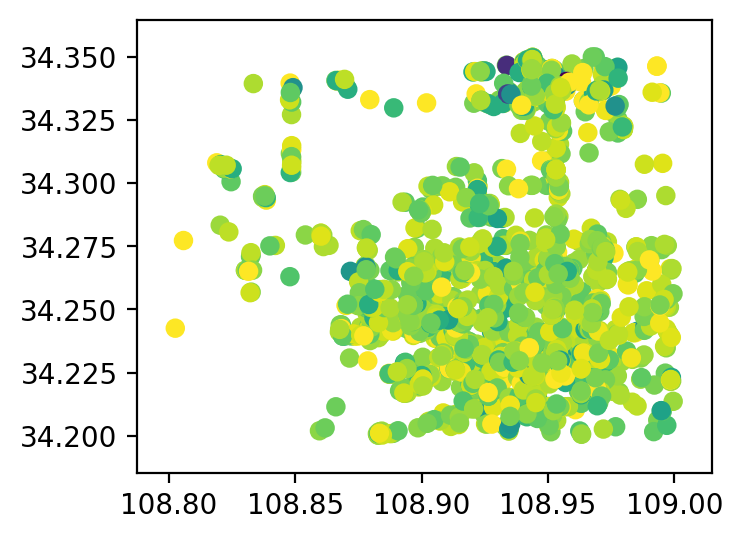

In [314]:
fields_extraction=['name','location_lat', 'location_lng','detail_info_tag','detail_info_overall_rating', 'detail_info_price'] #配置需要提取的字段，即列（columns）
save_path={'geojson':'../data/poiAll_gpd.geojson','shp':'../data/poiAll_gpd.shp','pkl':'../data/poiAll_gpd.pkl'} #分别存储为GeoJSON、Shapefile和pickle三种数据格式

def poi_json2GeoDF_batch(poi_paths,fields_extraction,save_path):

    '''funciton-.json格式POI数据批量转换为GeoDataFrame，需要调用转换.csv格式的POI数据为pandas的DataFrame函数json2df(poi_fn_csv)'''
    #循环读取与转换poi的.csv文件为pandas的DataFrame数据格式
    poi_df_dic={}
    i=0
    for key in poi_paths:
        for val in poi_paths[key]:
            poi_jsonPath=os.path.join(key,val)
            poi_df=json2df(poi_jsonPath) #注释掉了了json2df()函数内部的print("%s data type is not converted..."%(col))语句，以pass替代，减少提示内容，避免干扰
            print(val)
            poi_df_path=pathlib.Path(val)
            poi_df_dic[poi_df_path.stem]=poi_df
            
#             if i==2:break
            i+=1

    poi_df_concat=pd.concat(poi_df_dic.values(),keys=poi_df_dic.keys(),sort=True)
    #print(poi_df_concat.loc[['poi_0_delicacy'],:]) #提取index为 'poi_0_delicacy'的行，验证结果
    poi_fieldsExtraction=poi_df_concat.loc[:,fields_extraction]
    poi_geoDF=poi_fieldsExtraction.copy(deep=True)
    poi_geoDF['geometry']=poi_geoDF.apply(lambda row:Point(row.location_lng,row.location_lat),axis=1) 
#     crs_4326=CRS('epsg:32749') #配置坐标系统，参考：https://spatialreference.org/        
    poiAll_gpd=gpd.GeoDataFrame(poi_geoDF,crs='epsg:32749')     
    
    poiAll_gpd.to_pickle(save_path['pkl'])
    poiAll_gpd.to_file(save_path['geojson'],driver='GeoJSON')
    
    poiAll_gpd2shp=poiAll_gpd.reset_index() #不指定level参数，例如Level=0，会把多重索引中的所有索引转换为列
#     poiAll_gpd2shp.rename(columns={
#         'location_lat':'lat', 'location_lng':'lng',
#         'detail_info_tag':'tag','detail_info_overall_rating':'rating', 'detail_info_price':'price'},inplace=True)
    poiAll_gpd2shp.rename(columns={'location_lat':'lat', 'location_lng':'lng','detail_info_tag':'tag'},inplace=True)
    poiAll_gpd2shp.to_file(save_path['shp'],encoding='utf-8')
        
    return poiAll_gpd
            
poi_gpd=poi_json2GeoDF_batch(poi_paths,fields_extraction,save_path)
fig = plt.figure(figsize = (4,3), dpi = 200)
ax = fig.add_subplot(111)
poi_gpd.loc[['poi_0_delicacy'],:].plot(column='detail_info_overall_rating',ax = ax) #提取index为'poi_0_delicacy'的行查看结果


# 2.2 西安建筑高度数据

In [33]:
xian_path = '../xianBuildingHeight/xian_Project.shp'
data_high = gpd.read_file(xian_path)
data_high

,Id,Floor,geometry
0,0,4,"POLYGON ((293016.564 3794569.532, 293037.913 3..."
1,0,6,"POLYGON ((292754.318 3768746.174, 292852.300 3..."
2,0,6,"POLYGON ((292751.345 3768700.867, 292795.878 3..."
3,0,8,"POLYGON ((292790.495 3768723.697, 292797.429 3..."
4,0,2,"POLYGON ((292883.117 3768744.393, 292898.968 3..."
...,...,...,...
145042,0,2,"POLYGON ((342011.614 3806750.400, 342018.505 3..."
145043,0,3,"POLYGON ((343937.888 3780860.574, 343982.325 3..."
145044,0,6,"POLYGON ((343936.902 3780860.593, 343937.644 3..."
145045,0,6,"POLYGON ((344001.083 3780863.325, 344001.825 3..."


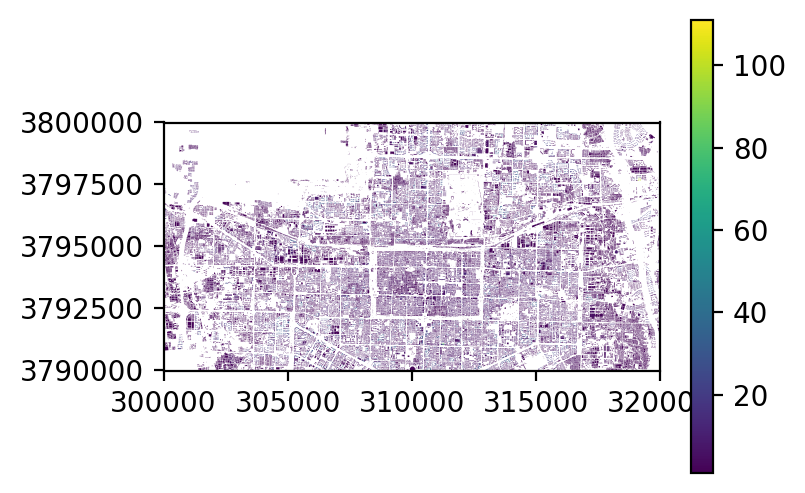

In [49]:
fig = plt.figure(figsize = (4,3), dpi = 200)
ax = fig.add_subplot(111)
ax.set_xlim(300000,320000)
ax.set_ylim(3790000,3800000)
data_high.plot(column='Floor',ax = ax, legend=True)


# 3. 分析

# 3.1 核密度估计

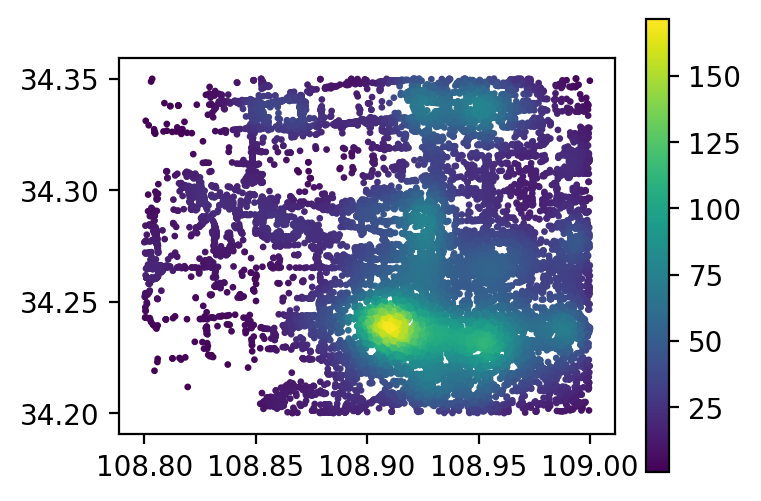

In [14]:
poi_gpd=pd.read_pickle('../data/poiAll_gpd.pkl') #读取已经存储为.pkl格式的POI数据，其中包括geometry字段，为GeoDataFrame地理信息数据，可以通过poi_gpd.plot()迅速查看数据。

poi_coordinates=poi_gpd[['location_lng','location_lat']].to_numpy().T  #根据stats.gaussian_kde()输入参数要求确定数组结构
poi_coordi_kernel=stats.gaussian_kde(poi_coordinates) #核密度估计
poi_gpd['poi_kde']=poi_coordi_kernel(poi_coordinates)

fig = plt.figure(figsize = (4,3), dpi = 200)
ax = fig.add_subplot(111)
poi_gpd.plot(marker=".",markersize=8,column='poi_kde',ax = ax,legend=True) #提取index为'poi_0_delicacy'的行查看结果


# 3.2  K-Means聚类

In [43]:
from sklearn.cluster import KMeans #导入K均值聚类算法

k = 5
data_k = data_high.Floor.values.reshape(-1,1)
km=KMeans(n_clusters=k)
km.fit(data_k)
data_high['label'] = km.labels_
print(data_high)

        Id  Floor                                           geometry  label
0        0      4  POLYGON ((293016.564 3794569.532, 293037.913 3...      2
1        0      6  POLYGON ((292754.318 3768746.174, 292852.300 3...      2
2        0      6  POLYGON ((292751.345 3768700.867, 292795.878 3...      2
3        0      8  POLYGON ((292790.495 3768723.697, 292797.429 3...      2
4        0      2  POLYGON ((292883.117 3768744.393, 292898.968 3...      0
...     ..    ...                                                ...    ...
145042   0      2  POLYGON ((342011.614 3806750.400, 342018.505 3...      0
145043   0      3  POLYGON ((343937.888 3780860.574, 343982.325 3...      0
145044   0      6  POLYGON ((343936.902 3780860.593, 343937.644 3...      2
145045   0      6  POLYGON ((344001.083 3780863.325, 344001.825 3...      2
145046   0      1  POLYGON ((344006.876 3780915.400, 344008.654 3...      0

[145047 rows x 4 columns]


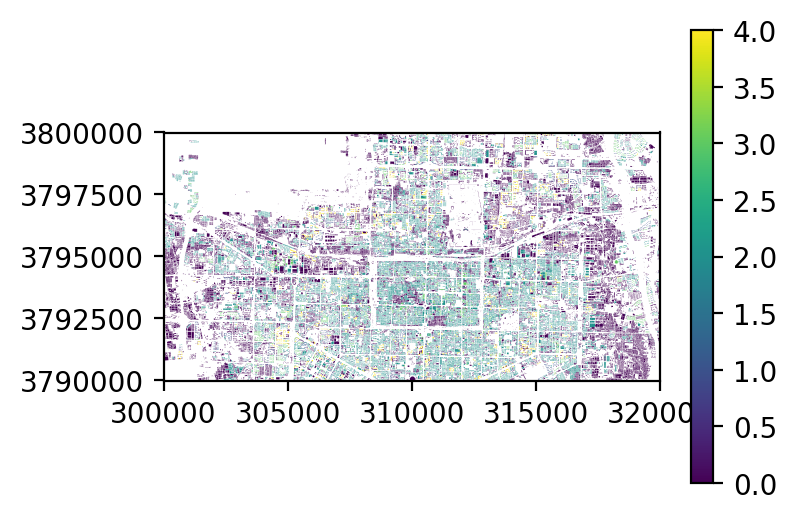

In [48]:
fig = plt.figure(figsize = (4,3), dpi = 200)
ax = fig.add_subplot(111)
ax.set_xlim(300000,320000)
ax.set_ylim(3790000,3800000)
data_high.plot(column='label',ax = ax, legend=True)